# Определение места для добычи нефти

Нефтедобывающей компании необходимо выбрать регион для разработки новых месторождений, где добыча принесёт наибольшую прибыль.


**Цели и задачи**
* В трёх нефтедобывающих регионах (по 10000 скважин в каждом) взяты пробы нефти, измерено качество сырья и объём запасов.
* Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
* Проанализировать возможную прибыль и убытки с помощью техники *Bootstrap*.



**Шаги для выбора локации**
* Поиск месторождения в выбранном регионе, определение для каждого значения признаков.
* Построение модели и оценка объёма запасов.
* Выбор месторождения с самыми высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины.
* Прибыль равна суммарной прибыли отобранных месторождений.



**Условия задачи:**
* Использовать модель линейной регрессии (остальные — недостаточно предсказуемые).
* При разведке региона исследованы `500` точек, из которых с помощью машинного обучения предстоит отобрать `200` лучших для разработки.
* При нынешних ценах один баррель сырья приносит `450` рублей дохода. Доход с каждой единицы продукта составляет `450` тыс. рублей, так как объём указан в тысячах баррелей.
* Выбрать регионы, в которых вероятность убытков меньше `2.5%`. Среди регионов, прошедших оценку рисков, выбрать один с наибольшей средней прибылью.



**Описание данных**
Данные находятся в трёх файлах: `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv` каждый из которых содержит следующие данные:
* `id` —  уникальный идентификатор скважины;
* `f0`, `f1`, `f2`  — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).



**План выполнения работы:**
1. Загрузка, обзор и исследование данных.
2. Обучение и проверка моделей.
3. Подготовка к расчёту прибыли.
4. Расчёт прибыли и рисков.
5. Общие выводы.

In [1]:
%%javascript
// отключение скролла в ячейках
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Загрузка, обзор и исследование данных

In [2]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Загрузка и обзор данных

Посмотрим на общий вид, сводную информацию, проверим количество пропущенных значений и наличие дубликатов в полученных для исследования файлах `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`.

Чтобы избежать дублирования кода создадим вспомогательную функцию *data_read()*.

In [3]:
# функция для просмотра основных сведений из таблицы загружаемого файла
def data_read(file_path):
    """
    input:        file_path (object) - путь к файлу
    output:       data (DataFrame) - таблица данных
    description:  функция загружает таблицу функцией read_csv(), выводит первые 10 строк на экран,
                  выводит информацию о данных методом info(), проверяет количество пропусков в данных, 
                  считает количество дубликатов
    """
    # считывание данных из переданного .csv файла с помощью метода read_csv() и анализ содержащихся в нём данных
    df = pd.read_csv(file_path)
    display(df.head(10))
    display(df.info())
    display(df.isna().sum())
    print('Количество дубликатов:', sum(df.duplicated()))
    return df

In [4]:
# чтение файла geo_data_0.csv
df_0 = data_read('/datasets/geo_data_0.csv')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0


In [5]:
# чтение файла geo_data_1.csv
df_1 = data_read('/datasets/geo_data_1.csv')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0


In [6]:
# чтение файла geo_data_2.csv
df_2 = data_read('/datasets/geo_data_2.csv')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0


* Данные успешно загружены и проведено предварительное знакомство с ними.
* Таблица в каждом файле содержит `100000` записей. Полных дубликатов в данных нет, также отсутствуют пропущенные значения и нарушения стиля заголовков. Заголовки столбцов единообразны во всех файлах.
* Типы данных соотвествуют описанию.
* Перед использованием данных для построения моделей необходимо провести исследовательский анализ данных.

### Исследование данных

Для исследования данных посмотрим на основные описательные статистики по ним и построим гистограммы распределения частот в паре с гистограммами размаха по каждому признаку.

In [7]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def pair_chart(data, column_name, region):
    """
    input: data (pandas.Series)   - данные для построения гистограммы и диаграммы размаха
           column_name (str)      - наименование столбца данных
           region (str)           - наименование региона данных
    output: None
    description: Функция для построения парных графиков для исследуемого параметра:
                 - Первый график - гистограмма отображает распределение частот с помощью параметра stat = frequency
                 - Второй график - диаграмма размаха отображает максимальные границы выборки и выбросы 
    """

    labels = {'id': 'Уникальный идентификатор скважины',
              'f0': 'Признак точек f0',
              'f1': 'Признак точек f1',
              'f2': 'Признак точек f2',
              'product': 'Oбъём запасов в скважине'
              }

    sns.set()
    sns.set_palette(palette='CMRmap')
    f, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(
        f'{region} - {labels[column_name]}.\n Гистограмма частот.', fontsize=17)
    axes[0].set_ylabel('Количество', fontsize=13)
    axes[0].set_xlabel(f'{region} -{labels[column_name]}', fontsize=15)
    sns.histplot(data[column_name], bins=25, alpha=0.5, kde=True,
                 ax=axes[0], stat='frequency')

    axes[1].set_title(
        f'{region} - {labels[column_name]}.\n Диаграмма размаха.', fontsize=17)
    axes[1].set_xlabel('', fontsize=14)
    sns.boxplot(x=data[column_name], orient='h', ax=axes[1], palette='BuPu')

    plt.show()

In [8]:
# функция для перебора признаков
def show_parameter(data, region):
    columns = ['f0', 'f1', 'f2', 'product']
    for column in columns:
        pair_chart(data, column, region)


========================= Описательные статистики и графики для данных по Региону #0 =========================


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


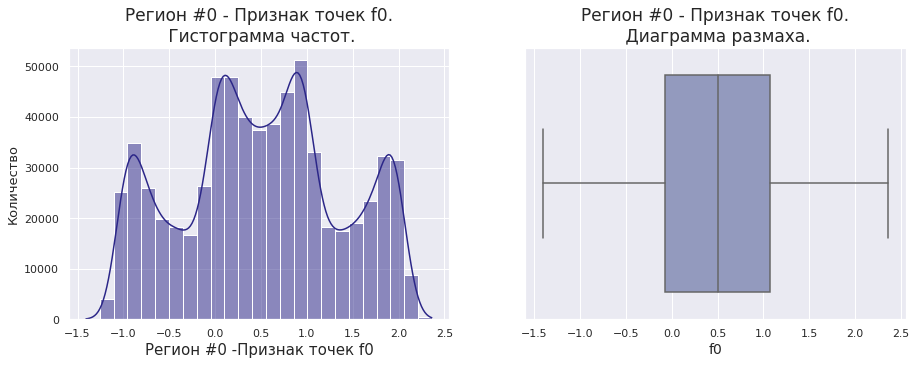

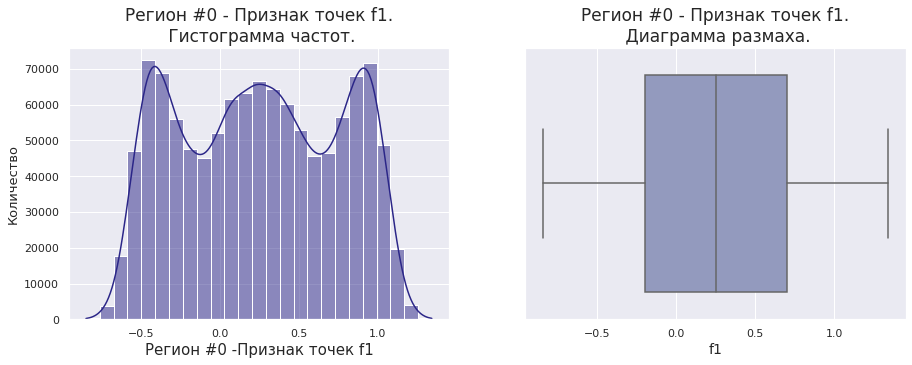

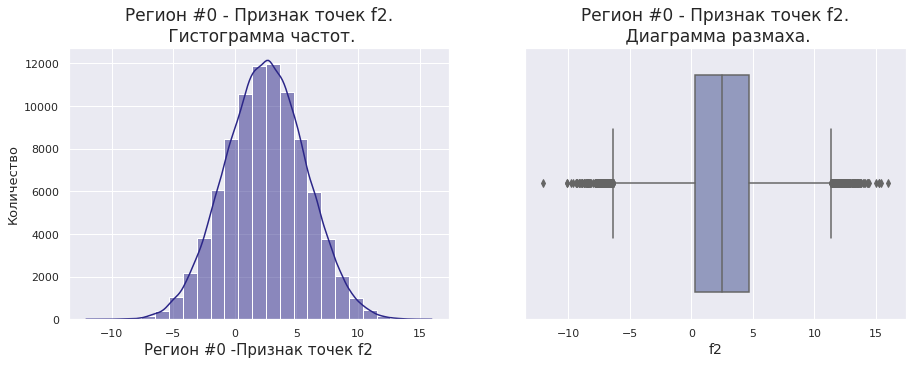

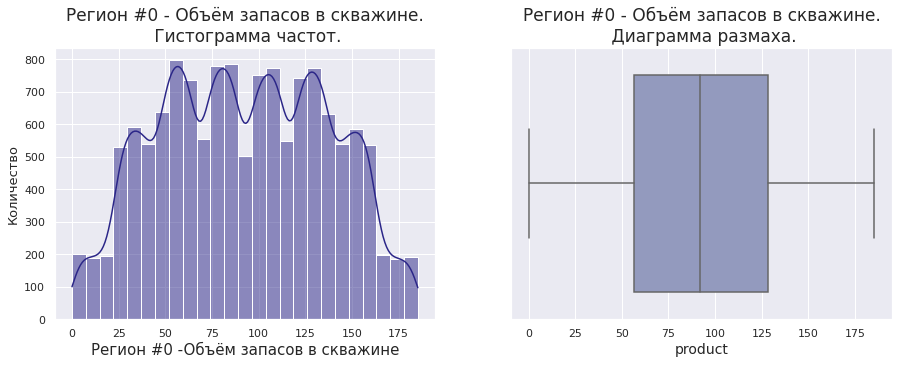


========================= Описательные статистики и графики для данных по Региону #1 =========================


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


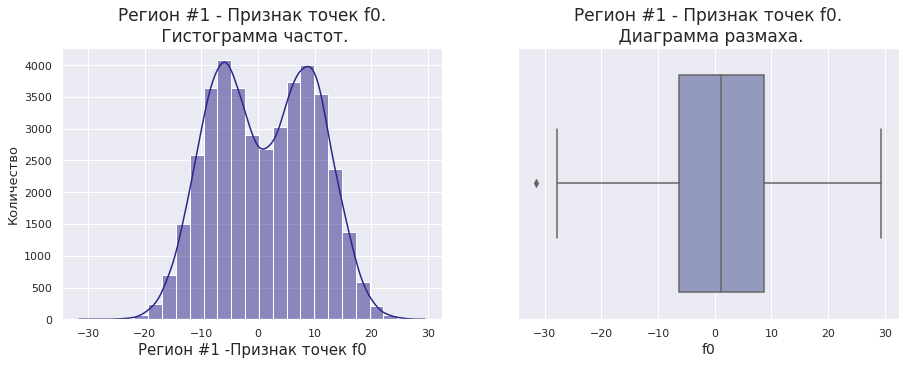

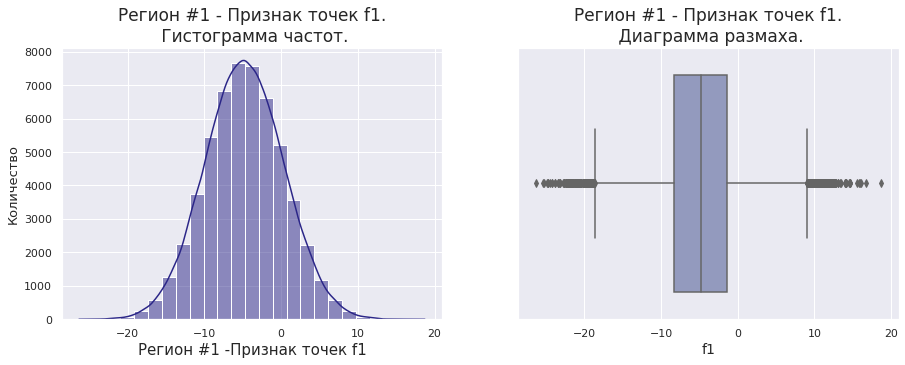

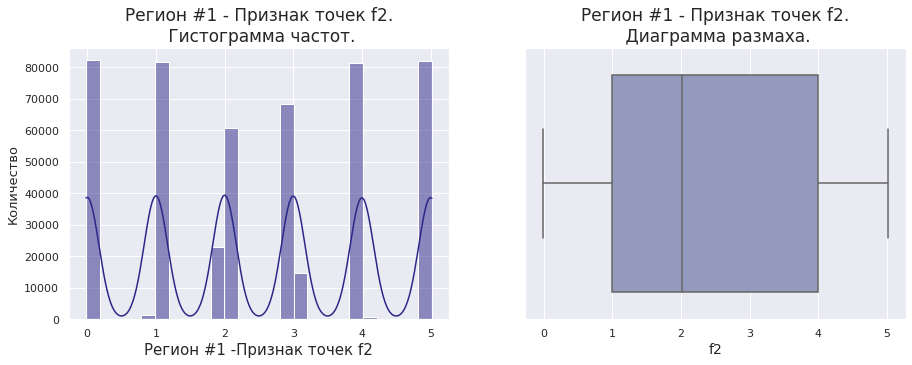

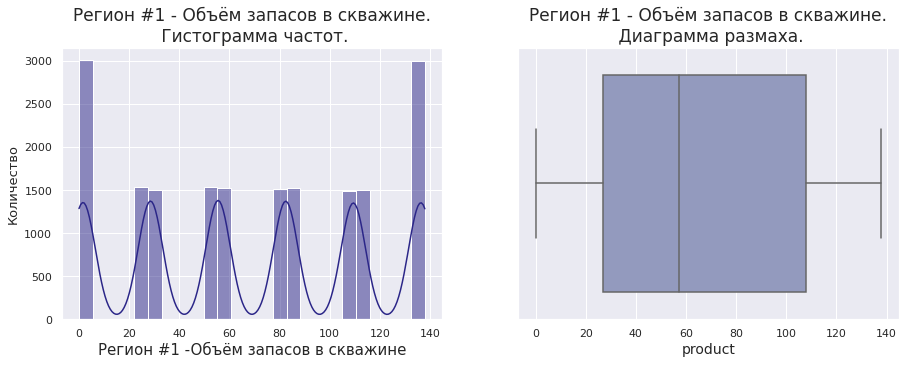


========================= Описательные статистики и графики для данных по Региону #2 =========================


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


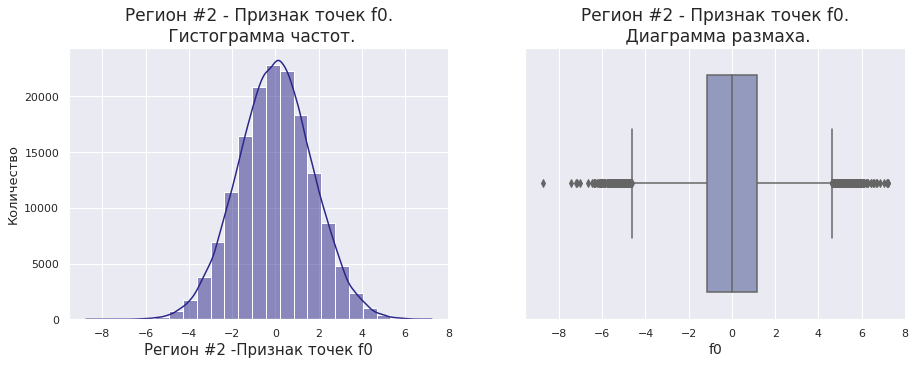

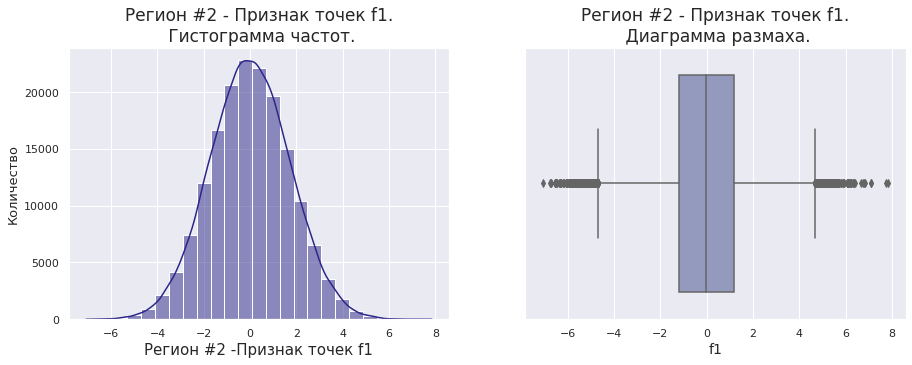

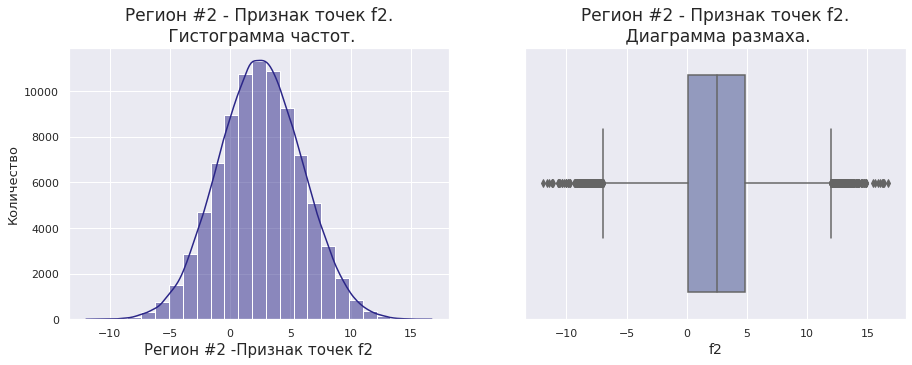

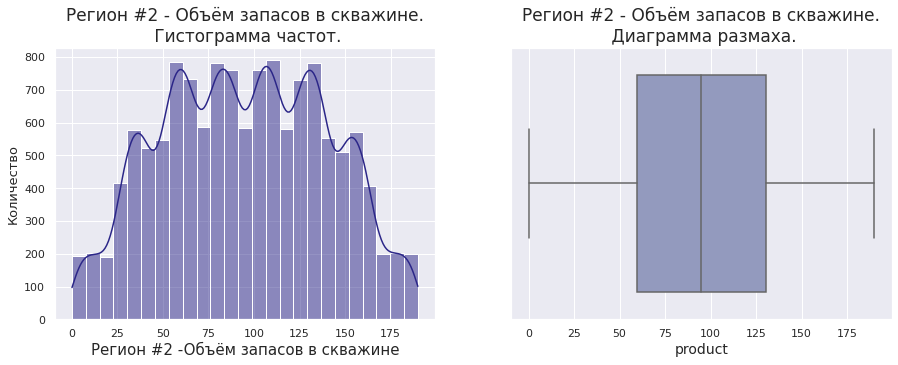

In [9]:
# перебор датафреймов и вызов функции show_parameter()
for data, region in [(df_0, 'Регион #0'), (df_1, 'Регион #1'), (df_2, 'Регион #2')]:
    print()
    print('=' * 25, end='')
    region_name = region.replace('Регион', 'Региону')
    print(
        f' Описательные статистики и графики для данных по {region_name} ', end='')
    print('=' * 25)
    display(data.describe())
    show_parameter(data, region)

* Как следует из графиков, некоторые данные характеризуются нормальным распределением, для других данных распределение отличается от нормального.
* Значения признаков `f0`, `f1`, `f2` отличаются друг от друга в пределах одного порядка. Попробуем обойтись без применения масштабирования признаков.
* В некоторых данных присуствуют выбросы. Оценим их долю по отношению к общему количеству данных.

Судя по диаграммам размаха, выбросы присутствуют в данных по Региону 0 - признак точек `f2`, в данных по Региону 1 - признаки точек `f0` и `f1` и в данных по Региону 2 - признаки точек `f0`, `f1` и `f2`. Оценим долю выбросов по отношению ко всем имеющимся данным. Для этого создадим пару вспомогательных функций:
* `outliers_value()` - для определения границы, за которой будут находится выбросы;
* `outliers_rate()` - для определения количества и доли выбросов по отношению ко всем данным.

In [10]:
# вспомогательная функция для определения границы выбросов
def outliers_value(df, column_name):
    """
    input:  df (pandas.DataFrame)  - исследуемый датафрейм
            column_name (str)      - название столбца (параметра, для которого будет определяться граница)
    output: val        (float)     - значение верхней границы, за которой будут находиться выбросы
    description: Функция находит и возвращает значения границ для исследуемого параметра за которыми будут 
                 находиться выбросы
    """
    # получение расчётных значений границ
    val_max = df[column_name].describe()['75%'] + (df[column_name].describe()
                                                   ['75%'] - df[column_name].describe()['25%']) * 1.5
    val_min = df[column_name].describe()['25%'] - (df[column_name].describe()
                                                   ['75%'] - df[column_name].describe()['25%']) * 1.5
    # проверка на превышение расчётных границ над фактическими значениями
    if val_max > df[column_name].max():
        val_max = df[column_name].max()
    if val_min < df[column_name].min():
        val_min = df[column_name].min()

    return val_min, val_max

Для хранения значений границ выбросов создадим двухуровневый словарь.

In [11]:
# пустой словарь для последующего хранения значений выбросов по ключам в виде имён параметров
outliers_values = {}

# сохранение значений границ выбросов в словарь outliers_values с помощью функции outliers_value()
for data, region in [(df_0, 'Регион #0'), (df_1, 'Регион #1'), (df_2, 'Регион #2')]:
    outliers_values[region] = {}
    for column in data.columns:
        if column != 'id':
            outliers_values[region][column] = outliers_value(data, column)

# просмотр полученного словаря
outliers_values

{'Регион #0': {'f0': (-1.408605306026996, 2.362330810854224),
  'f1': (-0.8482184970082173, 1.343769333804496),
  'f2': (-6.3532614580838125, 11.356097512311544),
  'product': (0.0, 185.3643474222929)},
 'Регион #1': {'f0': (-28.677901128779617, 29.42175461390372),
  'f1': (-18.670738069582377, 9.069937223519565),
  'f2': (-0.0181440867134202, 5.019720555223062),
  'product': (0.0, 137.94540774090564)},
 'Регион #2': {'f0': (-4.643524223522959, 4.639771092118378),
  'f1': (-4.682565825428671, 4.671424081839961),
  'f2': (-6.962293786328402, 11.951446027690594),
  'product': (0.0, 190.0298383433513)}}

In [12]:
# вспомогательная функция для определения количества и доли выбросов
def outliers_rate(df, column_name, outliers_values=outliers_values):
    """
    input: df (pandas.DataFrame)   - исследуемый датафрейм
           column_name  (str)      - название столбца (параметра, для которого будут находиться количество 
                                     и доля выбросов)
           outliers_values (dict)  - словарь с границами выбросов
    output: print() значения количества и доли выбросов
    description: Функция расчитывает и выводит на печать значения количества и доли выбросов по отношению ко всем данным
    """
    outliers_count_max = df.loc[df[column] > outliers_values[1]].shape[0]
    outliers_count_min = df.loc[df[column] < outliers_values[0]].shape[0]
    outliers_count = outliers_count_max + outliers_count_min
    rate = round(outliers_count / df.shape[0] * 100, 2)
    
    print('| {: <60}|'.format(f'Количество выбросов для параметра «{column_name}»:'), end='')
    print('{: >9d} |'.format(outliers_count), end='')
    print('{: >9} |'.format(f'{str(rate)}%'))
    print('-' * 85)
    
    return None

In [13]:
# перебор датафреймов и вызов функции outliers_rate()
for data, region in [(df_0, 'Регион #0'), (df_1, 'Регион #1'), (df_2, 'Регион #2')]:
    print()
    print('-' * 85)
    print('| {: ^81} |'.format(region.upper()))
    print('-' * 85)
    for column in data.columns:
        if column != 'id':
            outliers_rate(data, column, outliers_values[region][column])
    print()


-------------------------------------------------------------------------------------
|                                     РЕГИОН #0                                     |
-------------------------------------------------------------------------------------
| Количество выбросов для параметра «f0»:                     |        0 |     0.0% |
-------------------------------------------------------------------------------------
| Количество выбросов для параметра «f1»:                     |        0 |     0.0% |
-------------------------------------------------------------------------------------
| Количество выбросов для параметра «f2»:                     |      506 |    0.51% |
-------------------------------------------------------------------------------------
| Количество выбросов для параметра «product»:                |        0 |     0.0% |
-------------------------------------------------------------------------------------


---------------------------------------------------

* Выбросов менее `1%` по отдельным данным.
* Так как физический смысл признаков неизвествен, сложно оценить адекватность распределений и выбросов. Оставим данные как есть.

### Выводы по загрузке, обзору и исследованию данных

* Данные успешно загружены и проведено предварительное знакомство с ними. Таблица в каждом файле содержит `100000` записей. Полных дубликатов в данных нет, также отсутствуют пропущенные значения и нарушения стиля заголовков. Заголовки столбцов единообразны во всех файлах.
* Некоторые данные характеризуются нормальным распределнием, для других данных распределение отличается от нормального.
* В нескольких признаках присутствуют выбросы. Их доля по отношению к общему количеству данных не превышает `1%`. Так как физический смысл признаков неизвестен, сложно оценить адекватность распределений и выбросов. По этой причине данные для дальнейшей работы оставлены без изменений как есть.

## Обучение и проверка моделей

### Выделение целевого признака

Выделим целевой признак и признаки для обучения для всех датафреймов. Целевым признаком будет выступать `product`, а признаками для обучения `f0`, `f1` и `f2`.

In [14]:
# разделение признаков на целевой и обучающие
feature_names = ['f0', 'f1', 'f2']
target_name = ['product']
X_0 = df_0[feature_names]
y_0 = df_0[target_name]
X_1 = df_1[feature_names]
y_1 = df_1[target_name]
X_2 = df_2[feature_names]
y_2 = df_2[target_name]

* Из данных для всех регионов выделен целевой признак `product`, остальные признаки, кроме уникального идентификатора скважины `id`, отнесены к обучающим.

### Обучение моделей на основе линейной регрессии

Используем модель линейной регрессии согласно техническому заданию и выведем средний запас предсказанного сырья и RMSE модели. Для решения этой задачи и сокращения количества кода при его многократном использовании создадим вспомогательную функцию *model_linear_regression()*.

Для сравнения адекватности модели сравним её со случайной, в которой все значения целевого признака равны его среднему значению.

Перед обучением зафиксируем генератор псевдослучайных чисел для последующей воспроизводимости полученных результатов.

In [15]:
# сохраним случайное состояние (число) в переменную RND
RND = 123

In [16]:
# функция для разделения выборок и обучения моделей на основе линейной регрессии
def model_linear_regression(X, y, region):
    """
    input: X (pandas.DataFrame) - признаки для обучения модели
           y (pandas.DataFrame) - целевой признак для модели
           region (str)         - выбранный регион
    output: y_valid (pandas.DataFrame) - целевой признак валидационной выборки 
            predict (numpy.ndarray)    - предсказания модели на валидационной выборке
            rmse (float)               - значение метрики RMSE для модели
            percent (float)            - процентное значение отличия RMSE случайной модели от обученной
    description: функция разделяет исходные данные на обучающую и валидационную выборки (75/25),
                 обучает модель линейной регрессии, осуществляет предсказания на валидационной выборке,
                 считает и выводит на экран среднее значение предсказаний и RMSE модели, возвращает значения
                 целевого признака валидационной выборки, предсказания модели на валидационной выборке,
                 значение метрики RMSE для модели и процентное значение отличия RMSE случайной модели от обученной
    """
    # разделение выборок на обучающую и валидационную части
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.25, random_state=RND)
    
    print('-' * 75)
    print('| {: ^71} |'.format(region.upper()))
    
    
    print('-' * 75)
    print('| {: <60}|'.format('Количество наблюдений в train-выборке:'), end='')
    print('{: >10d} |'.format(X_train.shape[0]))
    print('-' * 75)
    
    print('| {: <60}|'.format('Количество наблюдений в valid-выборке:'), end='')
    print('{: >10d} |'.format(X_valid.shape[0]))
    print('-' * 75)

    
    # обучение линейной регрессии
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)

    # предсказание обученной модели и определение метрики качества модели по RMSE
    predict_mean = predictions.mean()
    mse = mean_squared_error(y_valid, predictions)
    rmse = np.sqrt(mse)
    
    print('| {: <60}|'.format('Cредний запас предсказанного сырья, тыс. баррелей:'), end='')
    print('{: >10.3f} |'.format(predict_mean))
    print('-' * 75)


    print('| {: <60}|'.format('RMSE модели:'), end='')
    print('{: >10.3f} |'.format(rmse))
    print('-' * 75)

    # "предсказания" для случайной модели в виде среднего значения целевой переменной
    random_predictions = pd.Series(y_valid['product'].mean(), index=y_valid.index)
    random_mse = mean_squared_error(y_valid, random_predictions)
    random_rmse = np.sqrt(random_mse)
    
    print('| {: <60}|'.format('RMSE случайной модели:'), end='')
    print('{: >10.3f} |'.format(random_rmse))
    print('-' * 75)
    
    # отличие в процентном выражении результатов работы обученной модели от случайной
    percent = (random_rmse - rmse) * 100 / random_rmse

    print('| {: <60}|'.format('Процент отличий RMSE случайной модели от обученной, %:'), end='')
    print('{: >10.2f} |'.format(percent))
    print('-' * 75)
    
    return y_valid, predictions, rmse, percent

### Модель для региона 0

Получим средний запас предсказанного сырья и RMSE модели для региона 0.

In [17]:
# обучение модели на основе логистической регрессии для региона 0
y_0_valid, predict_0, rmse_0, diff_0 = model_linear_regression(X_0, y_0, 'Регион 0')

---------------------------------------------------------------------------
|                                РЕГИОН 0                                 |
---------------------------------------------------------------------------
| Количество наблюдений в train-выборке:                      |     75000 |
---------------------------------------------------------------------------
| Количество наблюдений в valid-выборке:                      |     25000 |
---------------------------------------------------------------------------
| Cредний запас предсказанного сырья, тыс. баррелей:          |    92.549 |
---------------------------------------------------------------------------
| RMSE модели:                                                |    37.648 |
---------------------------------------------------------------------------
| RMSE случайной модели:                                      |    44.408 |
---------------------------------------------------------------------------
| Процент от

* Метрика качества *RMSE* обученной модели для `региона 0` отличается от метрики качества случайной модели, за которую взяты средние значения целевого признака, лишь на `15,22%`.
* Рассматривать эту модель как обладающую какой-то достоверной прогностической способностью для `региона 0` в данном случае нельзя.

### Модель для региона 1

Получим средний запас предсказанного сырья и RMSE модели для региона 1.

In [18]:
# обучение модели на основе логистической регрессии для региона 1
y_1_valid, predict_1, rmse_1, diff_1 = model_linear_regression(X_1, y_1, 'Регион 1')

---------------------------------------------------------------------------
|                                РЕГИОН 1                                 |
---------------------------------------------------------------------------
| Количество наблюдений в train-выборке:                      |     75000 |
---------------------------------------------------------------------------
| Количество наблюдений в valid-выборке:                      |     25000 |
---------------------------------------------------------------------------
| Cредний запас предсказанного сырья, тыс. баррелей:          |    69.280 |
---------------------------------------------------------------------------
| RMSE модели:                                                |     0.895 |
---------------------------------------------------------------------------
| RMSE случайной модели:                                      |    45.819 |
---------------------------------------------------------------------------
| Процент от

* Метрика качества *RMSE* обученной модели для `региона 1` отличается от метрики качества случайной модели, за которую взяты средние значения целевого признака, на значимые `98,05%`.
* В данном случае для `региона 1` можно рассматривать эту модель как обладающую достоверной прогностической способностью.

### Модель для региона 2

Получим средний запас предсказанного сырья и RMSE модели для региона 2.

In [19]:
# обучение модели на основе логистической регрессии для региона 2
y_2_valid, predict_2, rmse_2, diff_2 = model_linear_regression(X_2, y_2, 'Регион 2')

---------------------------------------------------------------------------
|                                РЕГИОН 2                                 |
---------------------------------------------------------------------------
| Количество наблюдений в train-выборке:                      |     75000 |
---------------------------------------------------------------------------
| Количество наблюдений в valid-выборке:                      |     25000 |
---------------------------------------------------------------------------
| Cредний запас предсказанного сырья, тыс. баррелей:          |    95.099 |
---------------------------------------------------------------------------
| RMSE модели:                                                |    40.128 |
---------------------------------------------------------------------------
| RMSE случайной модели:                                      |    44.673 |
---------------------------------------------------------------------------
| Процент от

* Метрика качества *RMSE* обученной модели для `региона 2` отличается от метрики качества случайной модели, за которую взяты средние значения целевого признака, лишь на `10,17%`.
* Рассматривать эту модель как обладающую какой-то достоверной прогностической способностью для `региона 2` также нельзя.

### Выводы по обучению моделей на основе логистической регрессии

* Из данных для всех регионов выделен целевой признак `product`, остальные признаки, кроме уникального идентификатора скважины `id` отнесены к обучающим.
* В `регионe 0` и `регионe 2` средний показатель запаса предсказанного сырья составил `92.549` и `95.099` соответственно, что выше, чем для `региона 1` с аналогичным значением, равным `69.28`. Однако отличия *RMSE* для данных регионов от аналогичной метрики качества случайных моделей невысоки и в процентном отношении составляют `15.22%` и `10.17%` соответственно. Это свидетельствует о том, что прогностические качества полученных логистических моделей для данных регионов низкие.
* В `регионе 1` средний показатель запаса предсказанного сырья составляет, как было указано в предыдущем пункте, `69.28` тыс. баррелей, что ниже, чем у остальных регионов. Однако, отличие *RMSE* в данном регионе от аналогичной метрики качества случайной модели составило в процентном отношении `98.05%`. Это говорит о более лучшем качестве модели по сравнению с другими регионами и её более достоверной прогностической способности.

## Подготовка к расчёту прибыли

Для подготовки к расчёту прибыли необходимо определить достаточный объём сырья для безубыточной разработки новой скважины и сравнить полученный объём сырья со средним предсказанным запасом, рассчитанным для каждого региона.

Расчёт будет произведён по следующим данным:

* `COST_PER_DEV` - бюджет на разработку скважин в регионе - 10 млрд. рублей;
* `MAX_WELLS_PER_DEV`, `SAMP_WELLS_PER_DEV` - при расчёте выбирают 200 лучших скважин из 500 в выборке;
* `PROFIT_PER_UNIT` - доход с каждой единицы продукта составляет 450 тыс. рублей.

Значения для расчёта.

In [20]:
# создание переменных с данными для расчёта прибыли
COST_PER_DEV = 10 ** 10
MAX_WELLS_PER_DEV = 200
SAMP_WELLS_PER_DEV = 500
PROFIT_PER_UNIT = 4.5 * 10 ** 5

Рассчитаем средний бюджет на разработку одной из 200 лучших скважен, разделив общий бюджет на количество скважен. Расчёт будет произведён по формуле:

* **cost_per_unit = cost_per_dev / max_wells_per_dev**

In [21]:
# расчёт среднего бюджета на открытие одной скважины
cost_per_unit = COST_PER_DEV / MAX_WELLS_PER_DEV
print(f'Средний бюджет на открытие одной скважины: {round(cost_per_unit / 1e+6, 3)} млн. руб.')

Средний бюджет на открытие одной скважины: 50.0 млн. руб.


Зная средний бюджет на открытие одной скважины и величину дохода с каждой единицы продукта, рассчитаем минимальный объём, которым должна располагать каждая скважина, чтобы достичь значения безубыточности. Расчёт произведём по формуле:

* **min_volume = cost_per_unit / profit_per_unit**

In [22]:
# расчёт достаточного объёма сырья
min_volume = cost_per_unit / PROFIT_PER_UNIT
print(f'Минимальный объём продукта с одной скважины для безубыточной разработки: {round(min_volume, 3)}')

Минимальный объём продукта с одной скважины для безубыточной разработки: 111.111


### Выводы

* Средний бюджет на открытие одной скважины составляет `50 млн.` руб.
* Минимальный объём продукта для безубыточной разработки составляет `111.111`. Данный показатель рассчитан при условии выбора `200` лучших скважин из `500` в выборке.
* Рассчитанное значение минимального объёма продукта для безубыточной разработки превышает средние значения предсказанных запасов скважин по всем регионам.

## Расчёт прибыли и рисков

### Расчёт прибыли

Расчёт прогнозируемой прибыли выполним следующим образом:
* Выберем случайно `500` скважин и из них отберём `200` с масимальными предсказанными показателями среднего запаса сырья.
* Определим общее количество прогнозируемого объёма сырья, просуммировав целевое значение.
* Рассчитаем прибыль для полученного объёма сырья.

In [23]:
# сброс индексов и сохранение значений целевого признака в соотвествующие переменные
y_0_valid = pd.Series(y_0_valid['product']).reset_index(drop=True)
y_1_valid = pd.Series(y_1_valid['product']).reset_index(drop=True)
y_2_valid = pd.Series(y_2_valid['product']).reset_index(drop=True)

In [24]:
# сохранение предсказанных значений объёма сырья в соотвествующие переменные
predict_0 = pd.Series(*predict_0.reshape(1,-1))
predict_1 = pd.Series(*predict_1.reshape(1,-1))
predict_2 = pd.Series(*predict_2.reshape(1,-1))

Для расчёта и отображения возможной прибыли по регионам создадим вспомогательную функцию *predicted_profit()*.

In [25]:
# вспомогательная функция для расчёта и отображения возможной прибыли
def predicted_profit(target, predicts, region, rnd=RND, return_res=False):
    """
    input:  target   (pd.Series) - значения объёма запаса сырья в скважинах
            predicts (pd.Series) - предсказания линейной модели для объёма сырья
            region (str)         - наименование исследуемого региона
            rnd (int)            - начальное состояние генератора псевдослучайных чисел
    output: top_mean (float)     - средний запас сырья по скважинам
            profit (float)       - прогнозируемая прибыль для полученного объёма сырья
    description: - Функция создаёт выборку размера SAMP_WELLS_PER_DEV, выбирает из неё MAX_WELLS_PER_DEV 
                   максимальных значений и по полученной выборке рассчитывает среднее значение объёма сырья
                   для выбранных скважин, суммарный целевой объём сырья, возможную прибыль для полученного объёма сырья,
                   при вызове с параметром return_res=True возвращает прогнозируемую прибыль для полученного объёма сырья
    """
    sample_predicts = predicts.sample(n=SAMP_WELLS_PER_DEV,
                                   random_state=rnd)
    top_predicts = sample_predicts.sort_values(ascending=False)[:MAX_WELLS_PER_DEV]
    top_targets = target[top_predicts.index]
    top_mean = top_targets.mean()
    
    volume = sum(top_targets)
    
    # расчёт значения прибыли
    profit = volume * PROFIT_PER_UNIT - COST_PER_DEV
    
    if return_res != True:
        print('-' * 85)
        print('| {: ^81} |'.format(region.upper()))
        
        print('-' * 85)
        print('| {: <65}|'.format('Средний запас сырья по скважинам с максимальным показателем:'), end='')
        print('{: >15.3f} |'.format(top_mean))
        print('-' * 85)
        
        print('| {: <65}|'.format('Суммарный целевой объём сырья:'), end='')
        print('{: >15.3f} |'.format(volume))
        print('-' * 85)
        
        print('| {: <65}|'.format('Прогнозируемая прибыль для полученного объёма сырья, млн.:'), end='')
        print('{: >15.3f} |'.format(profit / 1e+6))
        print('-' * 85)
        
        return top_mean
    else:
        return profit

In [26]:
# расчёт и отображение возможной прибыли для Региона 0
volume_0 = predicted_profit(y_0_valid, predict_0, 'Регион 0')

-------------------------------------------------------------------------------------
|                                     РЕГИОН 0                                      |
-------------------------------------------------------------------------------------
| Средний запас сырья по скважинам с максимальным показателем:     |        115.394 |
-------------------------------------------------------------------------------------
| Суммарный целевой объём сырья:                                   |      23078.712 |
-------------------------------------------------------------------------------------
| Прогнозируемая прибыль для полученного объёма сырья, млн.:       |        385.420 |
-------------------------------------------------------------------------------------


In [27]:
# расчёт и отображение возможной прибыли для Региона 1
volume_1 = predicted_profit(y_1_valid, predict_1, 'Регион 1')

-------------------------------------------------------------------------------------
|                                     РЕГИОН 1                                      |
-------------------------------------------------------------------------------------
| Средний запас сырья по скважинам с максимальным показателем:     |        114.413 |
-------------------------------------------------------------------------------------
| Суммарный целевой объём сырья:                                   |      22882.628 |
-------------------------------------------------------------------------------------
| Прогнозируемая прибыль для полученного объёма сырья, млн.:       |        297.182 |
-------------------------------------------------------------------------------------


In [28]:
# расчёт и отображение возможной прибыли для Региона 2
volume_2 = predicted_profit(y_2_valid, predict_2, 'Регион 2')

-------------------------------------------------------------------------------------
|                                     РЕГИОН 2                                      |
-------------------------------------------------------------------------------------
| Средний запас сырья по скважинам с максимальным показателем:     |        115.120 |
-------------------------------------------------------------------------------------
| Суммарный целевой объём сырья:                                   |      23024.025 |
-------------------------------------------------------------------------------------
| Прогнозируемая прибыль для полученного объёма сырья, млн.:       |        360.811 |
-------------------------------------------------------------------------------------


* При расчёте показателей для `200` наилучших скважин в выборке из `500` случайных средний запас сырья равен:
    * `115.394` - для `региона 0`
    * `114.413` - для `региона 1`
    * `115.120` - для `региона 2`
* Прогнозируемая прибыль для полученного объёма сырья для `региона 0` равна `385.420` млн. руб., для `региона 1` составляет `297.182` млн. руб. и для `региона 2` соотвествует `360.811` млн. руб.
* Для всех регионов средний запас сырья превосходит минимально необходимый объём `111.111`.

### Расчёт рисков

Расчёт прогнозируемого риска выполним следующим образом:
* Применим технику *bootstrap* с `1000` выборок, чтобы получить распределение значений прогнозируемой прибыли.
* Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [29]:
def risk_calc(target, predicts, region):
    """
    input:  target   (pd.Series) - значения объёма запаса сырья в скважинах
            predicts (pd.Series) - предсказания линейной модели для объёма сырья
            region (str)         - наименование исследуемого региона
    output: profit_mean (float)  - средняя прибыль
            loss_rate (float)    - риск убытков
    description:  - функция реализует технику bootstrap, количество выборок = bootstrap_samples.
                  - Функция берёт выборку размера SAMP_WELLS_PER_DEV, выбирает MAX_WELLS_PER_DEV наивысших
                    значений, считает общую прибыль и сохраняет её в списке profit_sample.
                  - Функция выводит:  оценку средней прибыли
                                      95% доверительный интервал (считается с помощью функции quantile)
                                      риск убытков 
    """
    bootstrap_samples = 1000
    alpha = 0.05
    profit_sample = []
    
    state = np.random.RandomState(RND)

    for i in range(bootstrap_samples):
        profit = predicted_profit(target, predicts, region, rnd=state, return_res=True)
        profit_sample.append(profit)

    profit_sample = pd.Series(profit_sample)
    profit_mean = profit_sample.mean() / 10 ** 6
    conf_int_left = profit_sample.quantile(alpha/2) / 10 ** 6
    conf_int_right = profit_sample.quantile(1 - alpha/2) / 10 ** 6
    
    loss_count = 0
    for i in profit_sample:
        if i < 0 :
            loss_count += 1
    loss_rate = loss_count / bootstrap_samples * 100
    
    print('-' * 65)
    print('| {: ^61} |'.format(region.upper()))
    
    print('-' * 65)
    print('| {: <45}|'.format('Средняя прибыль, млн. руб.:'), end='')
    print('{: >15.3f} |'.format(profit_mean))
    print('-' * 65)
    
    print('| {: <45}|'.format('2.5% квантиль:'), end='')
    print('{: >15.2f} |'.format(conf_int_left))
    print('-' * 65)
    
    print('| {: <45}|'.format('97.5% квантиль:'), end='')
    print('{: >15.2f} |'.format(conf_int_right))
    print('-' * 65)
    
    print('| {: <45}|'.format('Риск убытков, %:'), end='')
    print('{: >15.2f} |'.format(loss_rate))
    print('-' * 65)
    
    return profit_mean, loss_rate

In [30]:
# расчёт и отображение рисков Региона 0
profit_0, risk_0 = risk_calc(y_0_valid, predict_0, 'Регион 0')

-----------------------------------------------------------------
|                           РЕГИОН 0                            |
-----------------------------------------------------------------
| Средняя прибыль, млн. руб.:                  |        485.558 |
-----------------------------------------------------------------
| 2.5% квантиль:                               |          -0.12 |
-----------------------------------------------------------------
| 97.5% квантиль:                              |         992.86 |
-----------------------------------------------------------------
| Риск убытков, %:                             |           2.50 |
-----------------------------------------------------------------


In [31]:
# расчёт и отображение рисков Региона 1
profit_1, risk_1 = risk_calc(y_1_valid, predict_1, 'Регион 1')

-----------------------------------------------------------------
|                           РЕГИОН 1                            |
-----------------------------------------------------------------
| Средняя прибыль, млн. руб.:                  |        455.944 |
-----------------------------------------------------------------
| 2.5% квантиль:                               |          78.18 |
-----------------------------------------------------------------
| 97.5% квантиль:                              |         836.67 |
-----------------------------------------------------------------
| Риск убытков, %:                             |           1.10 |
-----------------------------------------------------------------


In [32]:
# расчёт и отображение рисков Региона 2
profit_2, risk_2 = risk_calc(y_2_valid, predict_2, 'Регион 2')

-----------------------------------------------------------------
|                           РЕГИОН 2                            |
-----------------------------------------------------------------
| Средняя прибыль, млн. руб.:                  |        338.389 |
-----------------------------------------------------------------
| 2.5% квантиль:                               |        -159.55 |
-----------------------------------------------------------------
| 97.5% квантиль:                              |         878.41 |
-----------------------------------------------------------------
| Риск убытков, %:                             |           9.30 |
-----------------------------------------------------------------


Для наглядного сравнения рассчитанных показателей скважин в различных регионах создадим сводную таблицу.

In [33]:
# создание сводной таблицы для сравнения расчётных показателей различных регионов
comparison = pd.DataFrame(
    [[round(rmse_0, 3), round(diff_0, 2), round(volume_0, 3), round(profit_0, 3), round(risk_0, 2)],
     [round(rmse_1, 3), round(diff_1, 2), round(volume_1, 3), round(profit_1, 3), round(risk_1, 2)],
     [round(rmse_2, 3), round(diff_2, 2), round(volume_2, 3), round(profit_2, 3), round(risk_2, 2)]],
    columns=['RMSE', 'Отличие от случайной модели, %',
             'Средний запас сырья, тыс. баррелей', 'Средняя расчётная прибыль, млн. руб.', 'Риск убытков, %'])

comparison = comparison.T.rename(columns={0: 'регион 0', 1: 'регион 1', 2: 'регион 2'})
comparison

,регион 0,регион 1,регион 2
RMSE,37.648,0.895,40.128
"Отличие от случайной модели, %",15.220,98.050,10.170
"Средний запас сырья, тыс. баррелей",115.394,114.413,115.120
"Средняя расчётная прибыль, млн. руб.",485.558,455.944,338.389
"Риск убытков, %",2.500,1.100,9.300


* При оценке рисков техникой *bootstrap* для `200` лучших скважин в выборке из `500` получены следующие значения:
    * `2.50%` - для `региона 0`
    * `1.10%` - для `региона 1`
    * `9.30%` - для `региона 2`
* Из предыдущего пункта следует, что только для `региона 1` выполняется условие задания по риску `(<2.5%)`. Для `региона 0` расчётное значение риска точно равно пороговому значению.
* Средняя прибыль, полученная с применением техники *bootstrap* составила:
    * `485.558 млн. руб.` - для скважин `региона 0`
    * `455.944 млн. руб.` - для скважин `региона 1`
    * `338.389 млн. руб.` - для скважин `региона 2`
* Для наглядного сравнения основных расчётных показателей необходимые данные объединены в сводную таблицу.

### Выводы по расчёту прибыли и рисков

* Согласно расчётам возможной прибыли для всех регионов запасы сырья превосходят минимально необходимый объём `111.111`.
* Прогнозируемая прибыль для полученного объёма сырья для `региона 0` равна `385.420` млн. руб., для `региона 1` составляет `297.182` млн. руб. и для `региона 2` соотвествует `360.811` млн. руб.
* Средняя прибаль. полученная после применения техники *bootstrap* составила `485.558` млн. руб. для скважин `региона 0`, `455.944` млн. руб. для скважин `региона 1` и `338.389` млн. руб. для скважин `региона 2`.
* При оценке рисков техникой *bootstrap* для `200` лучших скважин в выборке из `500` значения риска составили: `2.50%` - для `региона 0`, `1.10%` - для `региона 1` и `9.30%` - для `региона 2`.
* Только для `региона 1` выполняется условие задания по риску `(<2.5%)`;
* По риску убытков условию задания не соотвествует `регион 2`, который также характеризуется самой низкой средней расчётной прибылью из всех рассматриваемых регионов. Поэтому выбор необходимо осуществить между `регионом 0` и `регионом 1`.
* У `региона 0` на `6.5%` выше средняя расчётная прибыль. По среднему прогнозируемому запасу сырья `регион 0` и `регион 1` практически равны. Величина риска убытков для `региона 0` точно соответствует пороговому значению этого показателя по условиям задания и формально этот регион также это условие не выполняет.
* По сравнению с `регионом 0`, значение риска для `региона 1`, равное `1.1%` гарантированно выполняет условие задания по риску `(<2.5%)`. Кроме того, отличие модели от случайной в процентном выражении для `региона 1`, равное `98.05%` значимо выше аналогичного показателя для модели `региона 0`, равного `15.22%`. Это говорит о гораздо более высокой достоверности прогнозов модели для `региона 1`.

## Общие выводы

1. Осуществлены загрузка, обзор и исследование данных:
    * полученные в файлах `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv` данные были успешно загружены и проанализированы;
    * таблицы в каждом файле содержат `100000` записей, полных дубликатов в данных нет, также отсутствуют пропущенные значения и нарушения стиля заголовков;
    * заголовки столбцов единообразны во всех файлах, типы данных соотвествуют описанию;
    * некоторые данные характеризуются нормальным распределнием, для других данных распределение отличается от нормального;
    * в нескольких признаках присутствуют выбросы, их доля по отношению к общему количеству данных не превышает `1%` и так как физический смысл признаков неизвестен, данные оставлены без изменений как есть.


2. Выполнены обучение и проверка моделей:
    * из данных для всех регионов выделен целевой признак `product`, остальные признаки, кроме уникального идентификатора скважины `id` отнесены к обучающим;
    * в `регионe 0` и `регионe 2` средний показатель запаса предсказанного сырья составил `92.549` и `95.099` соответственно, однако отличия метрики *RMSE* для данных регионов от аналогичной метрики качества случайных моделей в процентном отношении составляют `15.22%` и `10.17%` соответственно, что свидетельствует о невысоких прогностических качествах полученных логистических моделей;
    * в `регионе 1` средний показатель запаса предсказанного сырья составил `69.28`, что ниже, чем у остальных регионов, однако метрика *RMSE* (`0.895`) в данном регионе значимо больше показателя качества случайной модели, равного `45.819`, что в процетном отношении равно `98.05%` и это говорит о гораздо более лучшем качестве модели по сравнению с другими регионами.


3. Проведена подготовка к расчёту прибыли:
    * cредний бюджет на открытие одной скважины составил `50 млн.` руб;
    * рассчитаный при условии выбора `200` лучших скважин из `500` минимальный объём продукта для безубыточной разработки равен `111.111` и данное значение превышает средние значения предсказанных запасов скважин по всем регионам.
    

4. Реализован расчёт прибыли и рисков:
    * прогнозируемая прибыль для полученного объёма сырья для `региона 0` равна `385.420` млн. руб., для `региона 1` составляет `297.182` млн. руб. и для `региона 2` соотвествует `360.811` млн. руб.;
    * cогласно расчётам возможной прибыли для всех регионов запасы сырья превосходят минимально необходимый объём `111.111`;
    * cредняя прибыль, полученная после применения техники *bootstrap* составила `485.558` млн. руб. для скважин `региона 0`, `455.944` млн. руб. для скважин `региона 1` и `338.389` млн. руб. для скважин `региона 2`;
    * при оценке рисков техникой *bootstrap* значения риска составили: `2.50%` - для `региона 0`, `1.10%` - для `региона 1` и `9.30%` - для `региона 2`;
    * только для `региона 1` выполняется условие задания по риску `(<2.5%)`.


5. Рекомендовано место для добычи:
    * `регион 2` сразу исключён из претендентов на рекомендацию, так как по риску убытков не соотвествует условию задания, а также характеризуется самой низкой средней расчётной прибылью из всех рассматриваемых регионов;
    * дальнейший выбор проводился между `регионом 0` и `регионом 1`;
    * для `региона 0` отмечены:
    
        * *достоинства*:
            * на `6.5%` большее значение средней расчётной прибыли по сравнению с `регионом 1`.
        * *недостатки*:
            * риск убытков в `2.5%`, что точно соответствует пороговому значению этого показателя по условиям задания `(<2.5%)`;
            * большое значение метрики *RMSE*, равное `37.648`;
            * невысокий процент (`15.22%`) отличий от результатов случайной модели.
        
    * для `региона 1` отмечены:
        * *достоинства*:
            * значение риска, равное `1.1%`, гарантированно выполняет условие задания по риску `(<2.5%)`;
            * значимое отличие модели от случайной, равное `98.05%`, что говорит о гораздо более высоком качестве модели;
            * более низкое значение метрики *RMSE*, равное `0.895`, против `37.648` для модели `региона 0`.
        * *недостатки*:
            * на `6.5%` меньшее значение средней расчётной прибыли по сравнению с `регионом 0`.
    * по среднему прогнозируемому запасу сырья `регион 0` и `регион 1` практически равны;
    * оценивая перечисленные достоинства и недостатки каждой из сравниваемых моделей, для бурения новых скважин рекомендуется `регион 1`, так как только для него гарантированно выполняется условие задания по риску, а сама модель по которой осуществлялся прогноз, характеризуется более высокими значениями метрик, что предполагает лучшую точность предсказаний и качество построенной модели.
     
    
    
**Исходя из всего вышесказанного, `регион 1` рекомендован для разработки новых месторождений.**